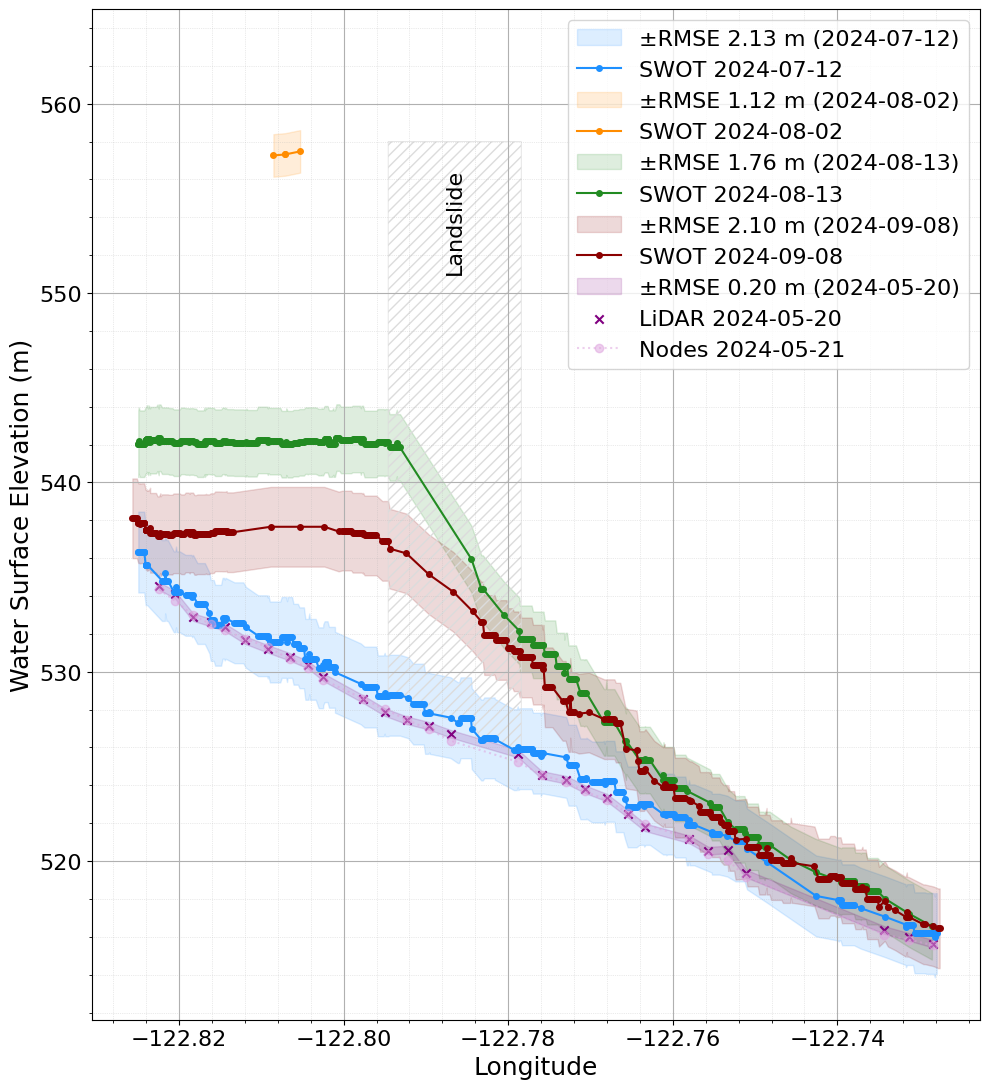

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

# === 1. Input configuration ===

data_sources = [
    {
        "raster_path": "/content/SWOT_WSE_2024-07-12.xlsx",
        "date": "2024-07-12",
        "color": "dodgerblue",
        "marker": "o",
        "linestyle": "-"
    },
    {
        "raster_path": "/content/SWOT_WSE_2024-08-02.xlsx",
        "date": "2024-08-02",
        "color": "darkorange",
        "marker": "o",
        "linestyle": "-"
    },
    {
        "raster_path": "/content/SWOT_WSE_2024-08-13.xlsx",
        "date": "2024-08-13",
        "color": "forestgreen",
        "marker": "o",
        "linestyle": "-"
    },
    {
        "raster_path": "/content/SWOT_WSE_2024-09-08.xlsx",
        "date": "2024-09-08",
        "color": "darkred",
        "marker": "o",
        "linestyle": "-"
    }
]

# Root Mean Square Error (RMSE) values by date, as computed in the Figure 2 analysis script
rmse_by_date = {
    "2024-05-20/21": 0.201,
    "2024-07-12": 2.135,
    "2024-08-02": 1.124,
    "2024-08-13": 1.758,
    "2024-09-08": 2.104
}

# Landslide extent and height
landslide_x_start = -122.794762
landslide_x_end = -122.7782996
landslide_y_max = 558

# === 2. Initialize figure ===
fig, ax = plt.subplots(figsize=(10, 11))
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Water Surface Elevation (m)', fontsize=18)

# Increase tick label font size
ax.tick_params(axis='both', which='major', labelsize=16)


# Main and minor grids
ax.grid(True)
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, alpha=0.5)
ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, alpha=0.5)

# === 3. Plot SWOT data for each date ===
for source in data_sources:
    date = source["date"]
    df = pd.read_excel(source["raster_path"])

    # Keep only valid raster/node data
    swot_data = df[df['data_type'].isin(['raster', 'nodes']) & df['WSE'].notna()].copy()
    swot_data['Longitude'] = pd.to_numeric(swot_data['Longitude'], errors='coerce')
    swot_data['WSE'] = pd.to_numeric(swot_data['WSE'], errors='coerce')
    swot_data.dropna(subset=['Longitude', 'WSE'], inplace=True)
    swot_data.sort_values('Longitude', inplace=True)

    rmse = rmse_by_date.get(date, 0.1)

    # Plot RMSE band
    SWOT = swot_data[swot_data['source'] == 'SWOT'].copy()
    ax.fill_between(
        SWOT['Longitude'],
        SWOT['WSE'] - rmse,
        SWOT['WSE'] + rmse,
        color=source["color"],
        alpha=0.15,
        label=f'±RMSE {rmse:.2f} m ({date})'
    )

    # Plot line and markers
    ax.plot(
        swot_data['Longitude'],
        swot_data['WSE'],
        linestyle=source["linestyle"],
        marker=source["marker"],
        markersize=4,
        color=source["color"],
        label=f'SWOT {date}'
    )

# === 4. Add LiDAR data (May 20–21) ===
try:
    df_lidar = pd.read_excel("/content/SWOT_vs_LiDAR_2024-05-20-21.xlsx")
    required_cols = {'Longitude', 'WSE', 'data_type'}
    if required_cols.issubset(df_lidar.columns):

        lidar_pts = df_lidar[(df_lidar['data_type'] == 'LiDAR') & df_lidar['WSE'].notna()].copy()
        lidar_nodes = df_lidar[(df_lidar['data_type'] == 'nodes') & df_lidar['WSE'].notna()].copy()

        lidar_pts.sort_values('Longitude', inplace=True)
        rmse_lidar = rmse_by_date.get("2024-05-20/21", 0.1)

        # RMSE band
        ax.fill_between(
            lidar_pts['Longitude'],
            lidar_pts['WSE'] - rmse_lidar,
            lidar_pts['WSE'] + rmse_lidar,
            color='purple',
            alpha=0.15,
            label=f'±RMSE {rmse_lidar:.2f} m (2024-05-20)'
        )

        # LiDAR points and nodes
        ax.scatter(lidar_pts['Longitude'], lidar_pts['WSE'], color='purple', marker='x', label='LiDAR 2024-05-20')
        ax.plot(lidar_nodes['Longitude'], lidar_nodes['WSE'], color='plum', marker='o', linestyle=':', alpha=0.5, label='Nodes 2024-05-21')
    else:
        print("Warning: Missing required columns in LiDAR file.")
except FileNotFoundError:
    print("Error: LiDAR file not found.")
except Exception as e:
    print(f"An error occurred while loading LiDAR data: {e}")

# === 5. Add gray hatched reference band from July 12 slope ===
df_0712 = pd.read_excel("/content/SWOT_WSE_2024-07-12.xlsx")
raster_0712 = df_0712[(df_0712['data_type'] == 'raster') & df_0712['WSE'].notna()].copy()

band_section = raster_0712[
    (raster_0712['Longitude'] >= landslide_x_start) &
    (raster_0712['Longitude'] <= landslide_x_end)
].copy()

band_section['Longitude'] = pd.to_numeric(band_section['Longitude'], errors='coerce')
band_section['WSE'] = pd.to_numeric(band_section['WSE'], errors='coerce')
band_section.dropna(subset=['Longitude', 'WSE'], inplace=True)
band_section.sort_values('Longitude', inplace=True)

ax.fill_between(
    band_section['Longitude'],
    band_section['WSE'],
    landslide_y_max,
    where=band_section['WSE'] <= landslide_y_max,
    interpolate=True,
    facecolor='none',
    edgecolor='gainsboro',
    hatch='///',
    linewidth=0.5
)

# === 6. Annotate landslide location ===
ax.text(
    (landslide_x_start + landslide_x_end) / 2,
    551,
    'Landslide',
    horizontalalignment='center',
    verticalalignment='bottom',
    rotation=90,
    fontsize=16,
    color='black'
)

# === 7. Final axis formatting and display ===
ax.set_ylim(top=565)
ax.legend(loc='upper right', fontsize=16)
plt.tight_layout()
plt.show()